<center>
<img src="https://drive.google.com/uc?id=1GkjZ9W02VQp4w4a4wA70NwRxDcwJJjWd" width="250" height="250" allow="autoplay"></img>


# <center> **Anisotrpic MRI superresolution using cGANs** <center/>
# <center> **Course Project:** CS736 (Medical Image Computing) <center/>
</center>
$
\fbox{
$ \scriptsize
Submitted \ To: \\
\normalsize
Prof. \ Suyash \ P. \ Awate \\
\normalsize
Department\ of\ CSE\\
\normalsize
IIT\ Bombay \\
$
} \ \ \ \ \ \ \ \ \ \ \
\fbox{   
$\scriptsize
Submitted\ By:  \\
\normalsize
Mohit\ Kumar \ Meena \\
\normalsize
Department\ of\ EE\\
\normalsize
IIT\ Bombay \\
\normalsize
213070021@iitb.ac.in
$
}
$


 Importing Libaries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import nibabel as nib
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model

## Mounting drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Preparation and Preprocessing**

**Original Dataset:** [ https://www.med.upenn.edu/cbica/brats-reg-challenge/]() \
**Description:**\
The dataset used for this project is taken from Brain tumor segmentation (BraTS) registration challenge hosted by ISBI (IEEE) 2022. This consist of 140 pre-operative and follow-up scans.\
For every subject, T1-weighted (along with it's contrast enhanced version), T2-weighted and FLAIR MRI sequences were given.\
In this cell our task is to visualize which MRI sequence suits best for our superresolution task.

Text(0.5, 1.0, 'T2 scan')

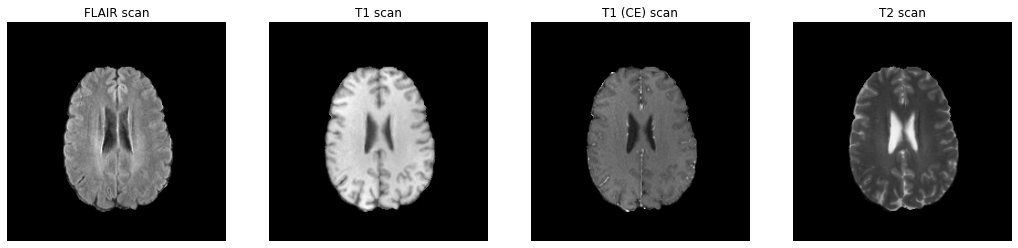

In [ ]:

# Path from google drive
path_flair="/content/drive/MyDrive/BraTSReg_Training_Data_v2/BraTSReg_001/BraTSReg_001_00_0000_flair.nii.gz"
path_t1="/content/drive/MyDrive/BraTSReg_Training_Data_v2/BraTSReg_001/BraTSReg_001_00_0000_t1.nii.gz"
path_t1_ce="/content/drive/MyDrive/BraTSReg_Training_Data_v2/BraTSReg_001/BraTSReg_001_00_0000_t1ce.nii.gz"
path_t2="/content/drive/MyDrive/BraTSReg_Training_Data_v2/BraTSReg_001/BraTSReg_001_00_0000_t2.nii.gz"

# Transposing the data from (240,240,155) to (155,240,240)
flair=np.transpose(nib.load(path_flair).get_fdata(),(2,1,0))
t1=np.transpose(nib.load(path_t1).get_fdata(),(2,1,0))
t1_ce=np.transpose(nib.load(path_t1_ce).get_fdata(),(2,1,0))
t2=np.transpose(nib.load(path_t2).get_fdata(),(2,1,0))

#plotting the results
plt.figure(figsize=(18,10))
plt.subplot(141)
plt.imshow(flair[90,:,:],cmap='gray')
plt.axis('off')
plt.title('FLAIR scan')
plt.subplot(142)
plt.imshow(t1[90,:,:],cmap='gray')
plt.axis('off')
plt.title('T1 scan')
plt.subplot(143)
plt.imshow(t1_ce[90,:,:],cmap='gray')
plt.axis('off')
plt.title('T1 (CE) scan')
plt.subplot(144)
plt.imshow(t2[90,:,:],cmap='gray')
plt.axis('off')
plt.title('T2 scan')
## Choosing FLAIR as an choice

In this cell, scans are cropped and resized\
(155,240,240) ---> (70,180,180)

(155, 240, 240)
(70, 180, 180)


Text(0.5, 1.0, 'Cropped and resized slice')

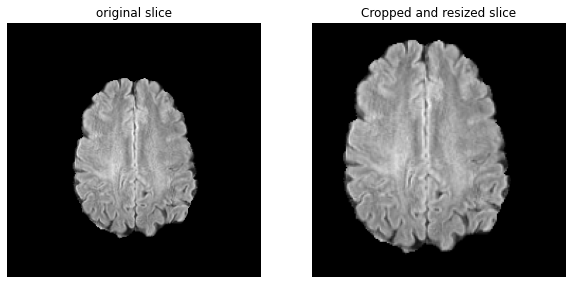

In [ ]:

## Drive mounted
path1="/content/drive/MyDrive/BraTSReg_Training_Data_v2/BraTSReg_001/BraTSReg_001_00_0000_flair.nii.gz"
file1=np.transpose(nib.load(path1).get_fdata(),(2,1,0))
print(file1.shape)
#Dimension 70*180*180
file2=file1[50:120,40:220,40:220]
print(file2.shape)
## Displaying results
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(file1[100,:,:],cmap='gray')
plt.axis('off')
plt.title('original slice')
plt.subplot(122)
plt.imshow(file2[50,:,:],cmap='gray')
plt.axis('off')
plt.title('Cropped and resized slice')

### Downsampling 

330


(-0.5, 63.5, 63.5, -0.5)

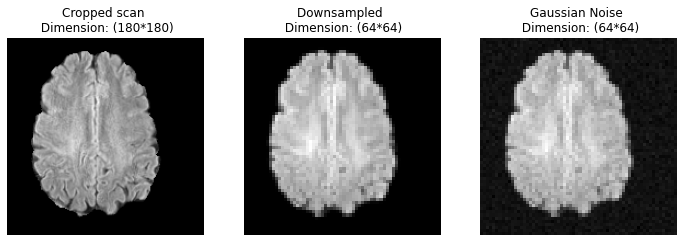

In [ ]:
# Downsampling cell
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(file2[50,:,:],cmap='gray')
plt.title('Cropped scan \n Dimension: (180*180)')
plt.axis('off')
## Downsampling from 180*180 ----> 64*64
resized = resize(file2,(70,64, 64))
plt.subplot(132)
plt.imshow(resized[50,:,:],cmap='gray')
plt.title('Downsampled \n Dimension: (64*64)')
plt.axis('off')

## Adding Gaussian Noise to the scans
row,col,s= resized.shape
mean = 0
var = np.random.randint(300,400) ## Maximum value: 1017 (slice 50)
print(var)
sigma = var**0.5
gauss1 = np.random.normal(mean,sigma,(row,col,s))
gauss1 = gauss1.reshape(row,col,s)
noisy1 = resized + gauss1
plt.subplot(133)
plt.imshow(noisy1[50,:,:],cmap='gray')
plt.title('Gaussian Noise \n Dimension: (64*64)')
plt.axis('off')


Saving the downsampled and gaussian added sample to the drive

In [ ]:
# saving to drive
path2='/content/drive/MyDrive/BraTSReg_Training_Data_v2'
list1=sorted(os.listdir(path2))
# list2=sorted(os.listdir(path2+'/'+list1[0]))
for i in range(len(list1)):
  list2=sorted(os.listdir(path2+'/'+list1[i]))
  flair_orig=np.transpose(nib.load(path2+'/'+list1[i]+'/'+list2[0]).get_fdata(),(2,1,0))
  flair_resized=flair_orig[50:120,40:220,40:220]
  ## Downsampling
  resized = resize(flair_resized, (70,64, 64))
  x,y,z= resized.shape
  mean = 0
  var = np.random.randint(300,400)
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(x,y,z))
  gauss = gauss.reshape(x,y,z)
  flair_dn = resized + gauss ## Downsampled and Noisy
  np.save("/content/drive/MyDrive/MRI_SR_dataset/HR/"+"flair_hr"+str(i+1),flair_resized)
  np.save("/content/drive/MyDrive/MRI_SR_dataset/LR/"+"flair_lr"+str(i+1),flair_dn)


(70, 180, 180)
(70, 64, 64)


(-0.5, 63.5, 63.5, -0.5)

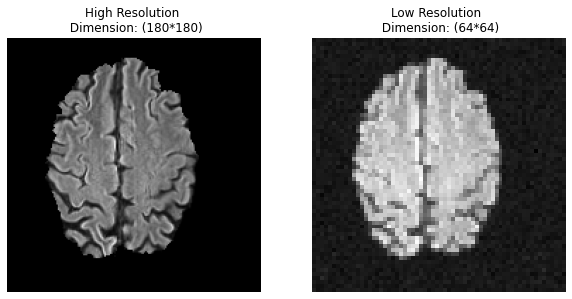

In [ ]:
# Sanity Check
load1=np.load("/content/drive/MyDrive/MRI_SR_dataset/HR/flair_hr10.npy")
load2=np.load("/content/drive/MyDrive/MRI_SR_dataset/LR/flair_lr10.npy")
plt.figure(figsize=(10,6))
print(load1.shape)
print(load2.shape)
plt.subplot(121)
plt.imshow(load1[60,:,:],cmap='gray')
plt.title('High Resolution \n Dimension: (180*180)')
plt.axis('off')
plt.subplot(122)
plt.imshow(load2[60,:,:],cmap='gray')
plt.title('Low Resolution \n Dimension: (64*64)')
plt.axis('off')

# **Implementation of the Model**

In this project, I had implemented [original SRGAN paper](https://arxiv.org/pdf/1609.04802.pdf) whose architecture is shown below: \\
\
<img src="https://drive.google.com/uc?id=12E7YwCF7OAvSe4rNeCiAng803LqpqE4T" width="800" height="400" allow="autoplay"></img>

Implementation of this architecture is followed in the cells below.

Generator

In [ ]:
# Implementation of Generator block 
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

#Implementation of Generator model
def Generator(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

Discriminator

In [ ]:
# Implementation of Discriminator section
def disc_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model
def Discriminator(disc_ip):

    df = 64
    #repeating discriminator block 8 times
    d1 = disc_block(disc_ip, df, bn=False)
    d2 = disc_block(d1, df, strides=2)
    d3 = disc_block(d2, df*2)
    d4 = disc_block(d3, df*2, strides=2)
    d5 = disc_block(d4, df*4)
    d6 = disc_block(d5, df*4, strides=2)
    d7 = disc_block(d6, df*8)
    d8 = disc_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)
def vgg19(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def combined(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# Function for normalizing 
def NORM(image):
  max=np.max(image)
  min=np.min(image)
  return (image-min)/(max-min+1e-8)


Reading the stored LR and HR images

In [ ]:
path_hr="/content/drive/Shareddrives/MIC/MRI_SR_dataset/HR"
path_lr="/content/drive/Shareddrives/MIC/MRI_SR_dataset/LR"
list_hr=sorted(os.listdir(path_hr))
list_lr=sorted(os.listdir(path_lr))

hr_images = []
for i in range(len(list_hr)):
  hr_array=np.load(path_hr+"/"+list_hr[i])
  for j in range(hr_array.shape[0]):
    norm_hr=NORM(hr_array[j,:,:])
    hr_images.append(norm_hr)

lr_images = []
for k in range(len(list_lr)):
  lr_array=np.load(path_lr+"/"+list_lr[k])
  for l in range(lr_array.shape[0]):
    norm_lr=NORM(lr_array[l,:,:])
    lr_images.append(norm_lr)
len(lr_images), len(hr_images)

(9450, 9450)

Text(0.5, 1.0, 'Low Resolution \n Dimension: (64*64)')

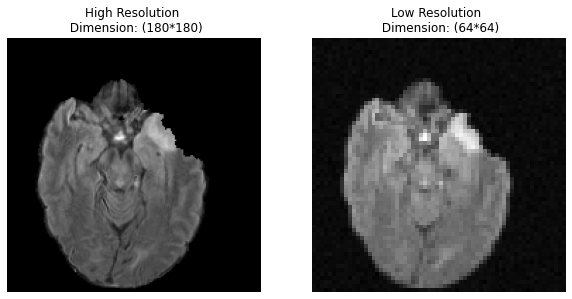

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(hr_images[0],cmap='gray')
plt.title('High Resolution \n Dimension: (180*180)')
plt.axis('off')
plt.subplot(122)
plt.imshow(lr_images[0],cmap='gray')
plt.axis('off')
plt.title('Low Resolution \n Dimension: (64*64)')

Resizing images as per the pretrained VGG19 model

(-0.5, 31.5, 31.5, -0.5)

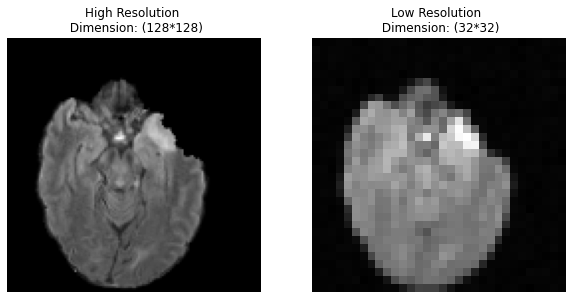

In [ ]:
# Resizing images as per the VGG model
# HR: 128*128
# LR: 32*32
plt.figure(figsize=(10,6))
lr_images=np.array(lr_images)
hr_images=np.array(hr_images)
hr2=resize(hr_images,(9800,128,128))
lr2=resize(lr_images,(9800,32,32))
hr_images.shape,hr2.shape
plt.subplot(121)
plt.imshow(hr2[0],cmap='gray')
plt.title('High Resolution \n Dimension: (128*128)')
plt.axis('off')
plt.subplot(122)
plt.imshow(lr2[0],cmap='gray')
plt.title('Low Resolution \n Dimension: (32*32)')
plt.axis('off')

In [ ]:
tf.keras.backend.clear_session()

I've used two loss functions (as mentioned in the paper): \
**Adversarial loss:** It is defined based on the probabilities of the discriminator over all training samples. \
**Content loss:**In this feature map obtained by the j-th convolution (after activation) before the i-th maxpooling layer within the VGG19 network. Then it's just euclidean between the feature representations of a reconstructed image and the reference image.


In [ ]:
lr_final=np.repeat(lr2[..., np.newaxis], 3, -1)
hr_final=np.repeat(hr2[..., np.newaxis], 3, -1)
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_final, hr_final,test_size=0.05, random_state=101)
hr_shape = (hr_train.shape[1], hr_train.shape[2],hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2],lr_train.shape[3])
print(hr_shape, lr_shape)
# print(type(lr_train))
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)
generator = Generator(lr_ip, num_res_block = 16)
# generator.summary()

discriminator = Discriminator(hr_ip)
optim=keras.optimizers.Adam(learning_rate=2e-4)
discriminator.compile(loss="binary_crossentropy", optimizer=optim, metrics=['accuracy'])
# discriminator.summary()

vgg = vgg19((128,128,3))
# print(vgg.summary())
vgg.trainable = False

gan_model = combined(generator, discriminator, vgg, lr_ip, hr_ip)
 
gan_model.compile( loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer=optim)
# gan_model.summary()

(128, 128, 3) (32, 32, 3)
80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
hr_train.shape

(9310, 128, 128, 3)

#training

In this model, I've used:\
Batch size: 1\
Epochs: 20

In [ ]:
import time
start_time=time.time()
batch_size = 1  
TrainLR_Batch = []
TrainLR_Batch = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    TrainLR_Batch.append(hr_train[start_idx:end_idx])
    TrainLR_Batch.append(lr_train[start_idx:end_idx])
        
epochs = 20

for e in range(epochs):
    # Assign a label of 0 to all fake images
    fake_label = np.zeros((batch_size, 1)) 
    # Assign a label of 1 to all real images.
    real_label = np.ones((batch_size,1)) 
    g_losses = []
    d_losses = []

    for b in tqdm(range(len(TrainLR_Batch))):
        lr_imgs = TrainLR_Batch[b] 
        hr_imgs = TrainLR_Batch[b] 
        
        fake_imgs = generator.predict_on_batch(lr_imgs) 
        
        #Initially training discriminator
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Training Generator
        discriminator.trainable = False
        
        #Averaging the discriminator loss
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extracting VGG features
        image_features = vgg.predict(hr_imgs)
     
        #Training the generator via GAN. 
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        #Saving losses to a list for visualization purposes
        d_losses.append(d_loss)
        g_losses.append(g_loss)
          
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculating average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 2 == 0:
       #Saving model after every 2nd epoch
        generator.save("/content/drive/Shareddrives/MIC/gen3_e_"+ str(e+1) +".h5")
        discriminator.save("/content/drive/Shareddrives/MIC/dis3_e_"+ str(e+1) +".h5")
        np.save("/content/drive/Shareddrives/MIC/g_loss.npy",g_loss)
        np.save("/content/drive/Shareddrives/MIC/d_loss.npy",d_loss)
end_time=time.time()
print(f'Time Taken: {(end_time-start_time)/60:.3f} minutes')

100%|██████████| 9310/9310 [23:35<00:00,  6.58it/s]


epoch: 1 g_loss: 10.621828122067273 d_loss: [0.17673422 0.98281418]


100%|██████████| 9310/9310 [23:24<00:00,  6.63it/s]

epoch: 2 g_loss: 7.75692434436219 d_loss: [0.01961047 0.99914071]



100%|██████████| 9310/9310 [23:12<00:00,  6.68it/s]


epoch: 3 g_loss: 6.9215776738107495 d_loss: [0.04205047 0.99860365]


100%|██████████| 9310/9310 [22:39<00:00,  6.85it/s]

epoch: 4 g_loss: 6.338345394537296 d_loss: [0.02917661 0.999087  ]



100%|██████████| 9310/9310 [22:30<00:00,  6.89it/s]


epoch: 5 g_loss: 5.879591714390519 d_loss: [0.01478655 0.99957035]


100%|██████████| 9310/9310 [22:36<00:00,  6.87it/s]

epoch: 6 g_loss: 5.536674221449409 d_loss: [0.07393669 0.99838883]



100%|██████████| 9310/9310 [24:06<00:00,  6.43it/s]


epoch: 7 g_loss: 5.20817208942526 d_loss: [0.0358311  0.99897959]


100%|██████████| 9310/9310 [23:50<00:00,  6.51it/s]

epoch: 8 g_loss: 4.922111128332247 d_loss: [0.00557919 0.99973147]



100%|██████████| 9310/9310 [23:12<00:00,  6.68it/s]


epoch: 9 g_loss: 4.664143696492968 d_loss: [0.01453761 0.99967777]


100%|██████████| 9310/9310 [22:15<00:00,  6.97it/s]

epoch: 10 g_loss: 4.432762610021615 d_loss: [3.92984465e-10 1.00000000e+00]



100%|██████████| 9310/9310 [23:14<00:00,  6.68it/s]


epoch: 11 g_loss: 4.261617939933639 d_loss: [0.04615255 0.9990333 ]


100%|██████████| 9310/9310 [24:03<00:00,  6.45it/s]

epoch: 12 g_loss: 4.141043717202067 d_loss: [0.04633856 0.99871106]



100%|██████████| 9310/9310 [22:22<00:00,  6.94it/s]


epoch: 13 g_loss: 3.9894611286537605 d_loss: [0.04133496 0.99887218]


100%|██████████| 9310/9310 [22:38<00:00,  6.85it/s]

epoch: 14 g_loss: 3.8768786488499023 d_loss: [0.04492012 0.99871106]



100%|██████████| 9310/9310 [24:01<00:00,  6.46it/s]


epoch: 15 g_loss: 3.743204578179486 d_loss: [0.02718669 0.99881847]


100%|██████████| 9310/9310 [24:41<00:00,  6.29it/s]

epoch: 16 g_loss: 3.6473807806579273 d_loss: [0.02280114 0.99897959]



100%|██████████| 9310/9310 [23:32<00:00,  6.59it/s]


epoch: 17 g_loss: 3.5294455517689616 d_loss: [0.02597057 0.99930183]


100%|██████████| 9310/9310 [22:17<00:00,  6.96it/s]

epoch: 18 g_loss: 3.4944700142134595 d_loss: [0.01660548 0.99930183]



100%|██████████| 9310/9310 [22:04<00:00,  7.03it/s]


epoch: 19 g_loss: 3.3816339325772 d_loss: [0.0180332  0.99924812]


100%|██████████| 9310/9310 [22:00<00:00,  7.05it/s]

epoch: 20 g_loss: 3.3103795701875947 d_loss: [0.02035128 0.99946294]


Time Taken: 462.810 minutes


In [ ]:

new_model = tf.keras.models.load_model('/content/drive/Shareddrives/MIC/gen_e_10.h5',compile=False)

# Show the model architecture
new_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

## Testing the model

In [ ]:
#loading any random LR image
test_lr=np.load("/content/drive/Shareddrives/MIC/MRI_SR_dataset/test/LR/flair_lr140.npy")
#converting it to the desired size
test_lr=resize(test_lr,(70,32,32))
test_lr=np.repeat(test_lr[..., np.newaxis], 3, -1)

#loading any random HR image
test_hr=np.load("/content/drive/Shareddrives/MIC/MRI_SR_dataset/test/LR/flair_lr140.npy")
#converting 
test_hr=resize(test_hr,(70,128,128))
test_hr=np.repeat(test_hr[..., np.newaxis], 3, -1)

gen3=load_model("/content/drive/Shareddrives/MIC/gen3_e_20.h5")

res=gen3.predict(test_lr[:,:,:,:])


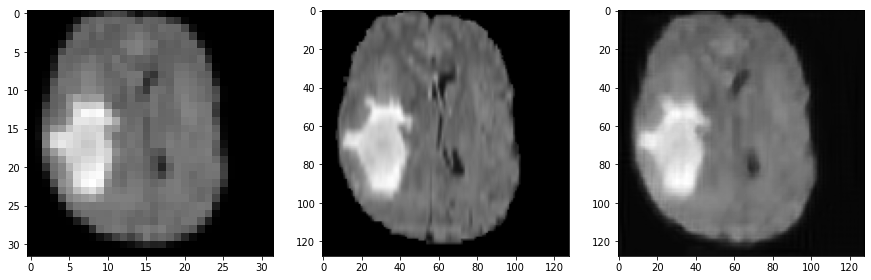

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(test_lr[30,:,:,1],cmap='gray')
plt.subplot(132)
plt.imshow(test_hr[30,:,:,1],cmap='gray')
plt.subplot(133)
plt.imshow(res[30,:,:,1],cmap='gray')

In [ ]:
import skimage
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
(score, diff) = ssim(test_hr[40,:,:,1], res[40,:,:,1], full=True)
diff = (diff * 255).astype("uint8")
peak_snr=psnr(res[40,:,:,1],test_hr[40,:,:,1],data_range=1 )
# 6. You can print only the score if you want
print("SSIM: {}".format(score))
print("PSNR: {}".format(peak_snr))

SSIM: 0.4759767936721663
PSNR: -59.96984590358678


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  if sys.path[0] == '':


SSIM: 0.46847508637423213
PSNR: -48.77071765625557


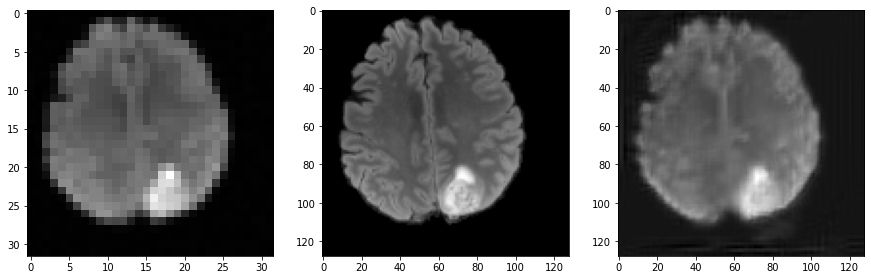

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(test_lr[40,:,:,2],cmap='gray')
plt.subplot(132)
plt.imshow(test_hr[40,:,:,2],cmap='gray')
plt.subplot(133)
plt.imshow(res[40,:,:,2],cmap='gray')

import skimage
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
(score, diff) = ssim(test_hr[4,:,:,2], res[4,:,:,2], full=True)
diff = (diff * 255).astype("uint8")
peak_snr=psnr(res[10,:,:,2],test_hr[10,:,:,2],data_range=1 )
# 6. You can print only the score if you want
print("SSIM: {}".format(score))
print("PSNR: {}".format(peak_snr))

SSIM: 0.7056971470871476
PSNR: 47.10947885620194


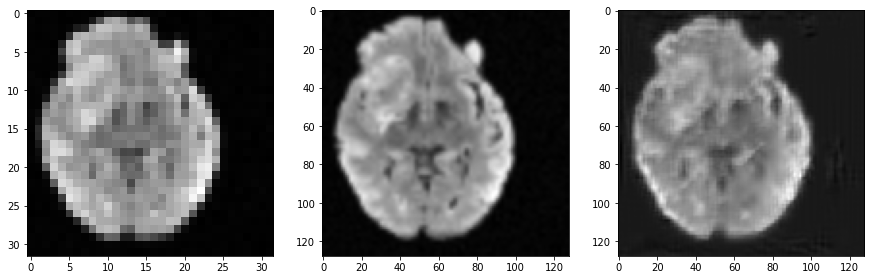

In [ ]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(test_lr[12,:,:,1],cmap='gray')
plt.subplot(132)
plt.imshow(test_hr[12,:,:,1],cmap='gray')
plt.subplot(133)
plt.imshow(res[12,:,:,1],cmap='gray')

import skimage
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
(score, _) = ssim(test_hr[12,20:100,20:100,1], res[12,20:100,20:100,1], full=True)
peak_snr=psnr(res[12,:,:,1],test_hr[12,:,:,1],data_range=1 )
# 6. You can print only the score if you want
print("SSIM: {}".format(score))
print("PSNR: {}".format(-peak_snr))

SSIM (Bilinear): 0.555459941344462
PSNR (Bilinear): 39.554298467087904
SSIM (Bicubic): 0.6310774594702159
PSNR (Bicubic): 37.025135121141055


Text(0.5, 1.0, 'Bicubic')

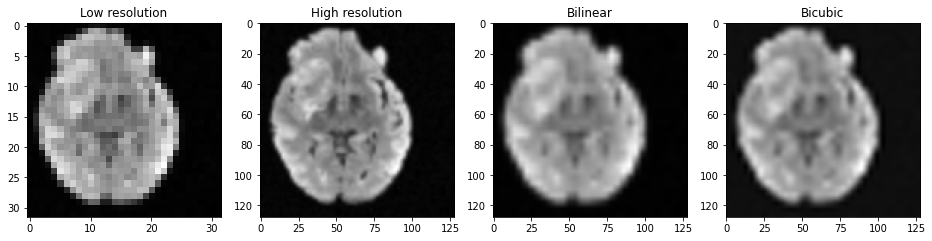

In [ ]:
import cv2
bicubic_img = cv2.resize(test_lr[12,:,:,1],None, fx = 4, fy = 4, interpolation = cv2.INTER_CUBIC)
bilinear_img=cv2.resize(test_lr[12,:,:,1],None, fx = 4, fy = 4, interpolation = cv2.INTER_LINEAR)

# Printing metrics
(score_bilinear, _) = ssim(test_hr[12,:,:,1], bilinear_img, full=True)
psnr_bilinear=psnr(test_hr[12,:,:,1],bilinear_img,data_range=1 )
print("SSIM (Bilinear): {}".format(score_bilinear))
print("PSNR (Bilinear): {}".format(-psnr_bilinear))
(score_bicubic, _) = ssim(test_hr[12,:,:,1], bicubic_img, full=True)
psnr_bicubic=psnr(test_hr[12,:,:,1],bicubic_img,data_range=1 )
print("SSIM (Bicubic): {}".format(score_bicubic))
print("PSNR (Bicubic): {}".format(-psnr_bicubic))



##  Displaying results
plt.figure(figsize=(16,12))
plt.subplot(141)
plt.imshow(test_lr[12,:,:,1],cmap='gray')
plt.title("Low resolution")
plt.subplot(142)
plt.imshow(test_hr[12,:,:,1],cmap='gray')
plt.title("High resolution")
plt.subplot(143)
plt.imshow(bilinear_img,cmap='gray')
plt.title("Bilinear")
plt.subplot(144)
plt.imshow(bicubic_img,cmap='gray')
plt.title("Bicubic")

In [ ]:
xt=np.arange(0,21.2

Text(0, 0.5, 'Loss')

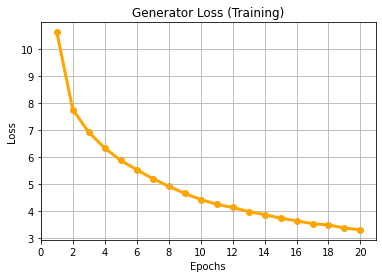

In [ ]:
loss_path="/content/drive/Shareddrives/MIC/g_loss2.npy"
x=np.arange(1,21)
xt=np.arange(0,21,2)
y=np.load(loss_path)
plt.grid('on')
plt.scatter(x,y,color='orange')
plt.plot(x,y,linewidth=3,color='orange',markersize=12 )
plt.xticks(xt)
plt.title('Generator Loss (Training)')
plt.xlabel('Epochs')
plt.ylabel('Loss')